# Import some libraries.

In [1]:
from qiskit.opflow import Z, I, X, Y
from qiskit.opflow import CircuitStateFn, StateFn, CircuitSampler, PauliExpectation, ListOp, AerPauliExpectation
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.utils import QuantumInstance
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector
from qiskit.algorithms.optimizers import ADAM, SPSA, GradientDescent
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.circuit.library.n_local import RealAmplitudes
from qiskit import Aer, execute, transpile, IBMQ
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError
from qiskit.providers.aer.noise import amplitude_damping_error, phase_damping_error, depolarizing_error
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
import numpy as np
import matplotlib.pyplot as plt

Let's define the number of qubits $N$. 

In [2]:
num_qub = 4

Let's define the transverse field Ising Hamiltonian on a 1D lattice: 
\begin{equation}
H=J_z\sum_{i=1}^{N} Z_{i} Z_{i+1} + h\sum_{i=1}^{N} X_{i},
\end{equation}
where $Z_{i}$ and $X_{i}$ are respectively the $Z$ and $X$ Pauli operators acting on the $i$-th qubit. The transverse-field Ising model is the quantum version of the classical Ising model. The Hamiltonian is composed by two types of terms: 

- nearest neighbour interactions determined by the alignment or anti-alignment of spin projections along the $z$ axis. The energy of these interactions is quantified by $J$. If $J<0$ we have the tendency of alignment between spins and so ferromagnetic coupling, while if $J>0$ the tendency is of anti-alignment and thus the coupling is anti-ferromagnetic. 
- an external magnetic field along the x axis which creates an energetic bias for the alignment of spins projections along the $x$ axis. The strenght of the magnetic field is determined by $h$. 

We have considered periodic boundary conditions in the system, namely $N+1 \equiv 1$.

In [3]:
J = np.ones(num_qub)
h = np.ones(num_qub)

def create_Hamiltonian(num_qub, J, h):
    H = 0
    if(num_qub == 2):
        return J[0]*(Z^Z) + h[0]*(X^I) + h[1]*(I^X)
    
    for i in range(num_qub):
        if(i==0 or i==num_qub-1):
            pauli_str = J[i]*Z
        else: 
            pauli_str = J[i]*I
        for j in range(num_qub):
            if(j!=i):
                if(j==i+1 or j==i-1):
                    pauli_str ^= Z
                else:
                    pauli_str ^= I
        H += pauli_str
        
    for i in range(num_qub):
        if(i==0):
            pauli_str = h[i]*X
        else: 
            pauli_str = h[i]*I
        for j in range(num_qub-1):
            if(j==i-1 and i!=0):
                pauli_str ^= X
            else:
                pauli_str ^= I
        H += pauli_str

    return H


H = create_Hamiltonian(num_qub, J, h)
print(H)

1.0 * ZZII
+ 1.0 * IZZI
+ 1.0 * IIZZ
+ 1.0 * ZIIZ
+ 1.0 * XIII
+ 1.0 * IXII
+ 1.0 * IIXI
+ 1.0 * IIIX


The ansatz considered is an hardware-efficient ansatz and consists in the alternation of rotations around the $Y$ axis on all the qubits followed by $CX$ (to create entanglement) on all possible qubit pairs. 

In [4]:
num_lay = 4
params = ParameterVector('θ', num_qub*num_lay)
entanglement = 'linear'
ansatz_gates = ['ry', 'rz']

def create_ansatz(num_qub, num_lay, params):
    ansatz = QuantumCircuit(num_qub)
    for i in range(num_lay):
        for j in range(num_qub):
            ansatz.ry(params[j+i*num_qub], j)
        ansatz.barrier()
        if(num_qub > 2):
            for j in range(num_qub-1):
                    #if(j == num_qub-1):
                    #    ansatz.cx(0, j)
                    #else:
                    ansatz.cx(j, j+1)
        else: 
            ansatz.cx(0, 1)
        ansatz.barrier()
    return ansatz

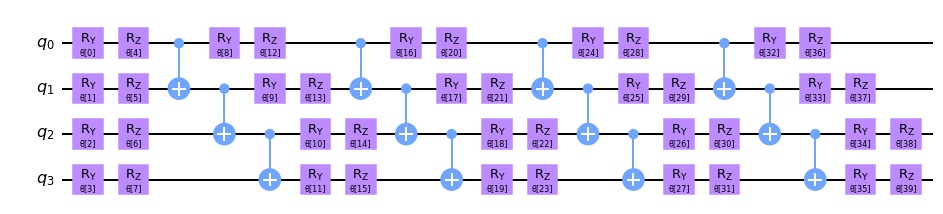

In [5]:
ansatz = EfficientSU2(num_qubits = num_qub, su2_gates = ansatz_gates, entanglement = entanglement, reps = num_lay)
ansatz = ansatz.decompose()
ansatz.draw('mpl')

Define a class which implement the VQE. 

In [6]:
provider         = IBMQ.load_account()

In [ ]:
class VQE:
    def __init__(self, ansatz, H, noise = 'no', prob = 0):
        self.H = H
        self.ansatz = ansatz
        self.epochs = epochs
        if(noise == 'no'):
            noise_model = None 
        if(noise == 'yes'):
            backend = provider.get_backend('ibmq_manila')
            noise_model = NoiseModel.from_backend(backend)
        if(noise == 'model'):
            noise_model = NoiseModel()
            #err_1gate = amplitude_damping_error(prob)
            err_1gate = phase_damping_error(prob)
            err_2gates = err_1gate.tensor(err_1gate)
            #err_1gate = depolarizing_error(prob, 1)
            #err_2gates = depolarizing_error(prob, 2)
            noise_model.add_all_qubit_quantum_error(err_1gate, ["u1", "u2", "u3"])
            noise_model.add_all_qubit_quantum_error(err_2gates, ["cx"])
            
        self.simulator = Aer.get_backend('qasm_simulator')
        self.shots = 10000
        #self.shots = 1
        self.lr = 0.1
        
        self.quantum_instance = QuantumInstance(backend = self.simulator, shots = self.shots, noise_model = noise_model)
        #self.optimizer = ADAM(maxiter=1, tol=1e-06, lr=self.lr, beta_1=0.9, beta_2=0.99, amsgrad=False)
        self.optimizer = GradientDescent(maxiter=1, learning_rate=self.lr)
        
        self.expectationer = PauliExpectation()
        #self.expectationer = AerPauliExpectation()
        

    def expectation_value(self, parameters):
        
        ansatz_dum = self.ansatz.bind_parameters(parameters)
        #ansatz_dum = create_ansatz(num_qub, num_lay, parameters)
        ansatz_state = CircuitStateFn(ansatz_dum)
        
        measurable_expression = StateFn(self.H, is_measurement=True).compose(ansatz_state) 
        
        expectation = self.expectationer.convert(measurable_expression)  

        sampler = CircuitSampler(self.quantum_instance).convert(expectation)

        return sampler.eval().real
            
    
    def gradient(self, parameters):
        
        gradients = np.zeros_like(parameters)
        for i in range(len(parameters)):
           
            shift = np.zeros_like(parameters)
            shift[i] = np.pi/2
            gradients[i] = (self.expectation_value(parameters + shift) - self.expectation_value(parameters - shift))/2
        
        return gradients
    
    def update(self, parameters):

        parameters, loss, it = self.optimizer.optimize(parameters.size,
                        lambda param: self.expectation_value(param),
                        gradient_function= lambda param: self.gradient(param), initial_point=parameters)
        
        #for i in range(self.epochs):
        #    loss = self.expectation_value(parameters)
        #    gradients = self.gradient(parameters)
        #    parameters -= self.lr*gradients 
        #    if(i%50==0):
        #    print(f"Epoch n. {i}: completed!") 
        
        return loss, parameters
  

In [ ]:
num_lay = 1 # 1 for 2 qubits, 2 for 3 qubits and 4 for 4 qubits
entanglement = 'linear'
ansatz_gates = ['ry', 'rz']

noise = 'model'
probs = np.linspace(0, 0.1, 11)
epochs = 500
exact_energy = min(np.real(np.linalg.eig(H.to_matrix())[0])) 
print("Exact ground energy: ", exact_energy)
ansatz = EfficientSU2(num_qubits = num_qub, su2_gates = ansatz_gates, entanglement = entanglement, reps = num_lay)
np.random.seed(1111)
parameters_common = np.pi * np.random.normal(size = len(ansatz.parameters))

for prob in probs: 
    losses = []
    ansatz = EfficientSU2(num_qubits = num_qub, su2_gates = ansatz_gates, entanglement = entanglement, reps = num_lay)
    parameters = parameters_common
    vqe = VQE(ansatz, H, noise = noise, prob = prob)
    for i in range(epochs):
        loss, parameters = vqe.update(parameters)
        losses.append(loss)
    np.savetxt('prob%.2f_losses' % prob, losses)
    np.savetxt('prob%.2f_fin_params' % prob, parameters)
    print(f"prob = %.2f: completed!" % prob)


In [ ]:
np.random.seed(1111)
parameters_common = np.pi * np.random.normal(size = len(ansatz.parameters))
ansatz = EfficientSU2(num_qubits = num_qub, su2_gates = ansatz_gates, entanglement = entanglement, reps = num_lay)
vqe = VQE(ansatz, H, noise = noise, prob = prob)


Plotting

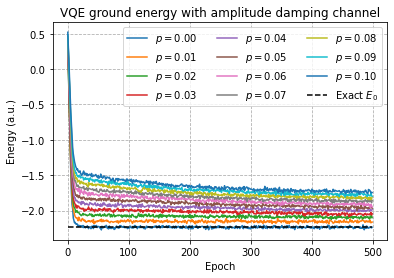

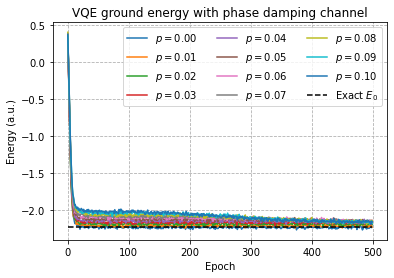

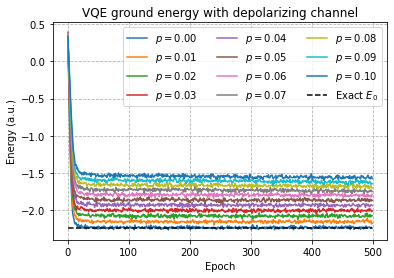

In [7]:
num_qub = 2
H = create_Hamiltonian(num_qub, J, h)
exact_energy = min(np.real(np.linalg.eig(H.to_matrix())[0])) 
fig = plt.figure()
ax = fig.add_subplot(111)
probs = np.linspace(0, 0.1, 11)
for prob in probs: 
    losses = np.loadtxt('Amplitude_damping_2qub_correct/prob%.2f_losses' % prob)
    ax.plot(losses, label = r'$p = %.2f$' % prob)
ax.plot(exact_energy*np.ones_like(range(len(losses))),'k--', label = r'Exact $E_{0}$')
ax.set_title("VQE ground energy with amplitude damping channel")
ax.set_ylabel("Energy (a.u.)")
ax.set_xlabel("Epoch")
plt.legend(ncol=3)
#ax.set_facecolor('#e4e6e8')
#plt.grid(color='white', linestyle = '--', linewidth = 2)
plt.grid(linestyle = '--')
fig.canvas.draw()
plt.savefig("2qub_same_init_amplitude_damping.pdf")


fig = plt.figure()
ax = fig.add_subplot(111)
for prob in probs: 
    losses = np.loadtxt('Phase_damping_2qub_correct/prob%.2f_losses' % prob)
    ax.plot(losses, label = r'$p = %.2f$' % prob)
ax.plot(exact_energy*np.ones_like(range(len(losses))),'k--', label = r'Exact $E_{0}$')
ax.set_title("VQE ground energy with phase damping channel")
ax.set_ylabel("Energy (a.u.)")
ax.set_xlabel("Epoch")
plt.legend(ncol=3)
#ax.set_facecolor('#e4e6e8')
#plt.grid(color='white', linestyle = '--', linewidth = 2)
plt.grid(linestyle = '--')
fig.canvas.draw()
plt.savefig("2qub_same_init_phase_damping.pdf")


fig = plt.figure()
ax = fig.add_subplot(111)
for prob in probs: 
    losses = np.loadtxt('Depolarizing_2qub_correct/prob%.2f_losses' % prob)
    ax.plot(losses, label = r'$p = %.2f$' % prob)
ax.plot(exact_energy*np.ones_like(range(len(losses))), 'k--', label = r'Exact $E_{0}$')
ax.set_title("VQE ground energy with depolarizing channel")
ax.set_ylabel("Energy (a.u.)")
ax.set_xlabel("Epoch")
plt.legend(ncol=3)
#ax.set_facecolor('#e4e6e8')
#plt.grid(color='white', linestyle = '--', linewidth = 2)
plt.grid(linestyle = '--')
fig.canvas.draw()
plt.savefig("2qub_same_init_depolarizing.pdf")



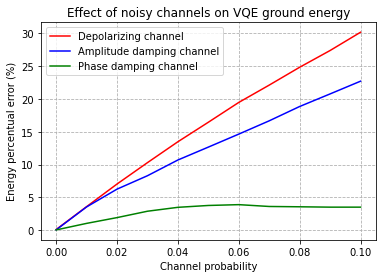

In [8]:
num_qub = 2
H = create_Hamiltonian(num_qub, J, h)
exact_energy = min(np.real(np.linalg.eig(H.to_matrix())[0])) 
fig = plt.figure()
ax = fig.add_subplot(111)
probs = np.linspace(0, 0.1, 11)
final_losses = []
for prob in probs: 
    losses = np.loadtxt('Depolarizing_2qub_correct/prob%.2f_losses' % prob)
    final_losses.append(np.mean(losses[-100:]))
final_errs = 100*np.abs((final_losses-exact_energy)/exact_energy)
ax.plot(probs, final_errs, label = 'Depolarizing channel', color = 'red')

final_losses = []
for prob in probs: 
    losses = np.loadtxt('Amplitude_damping_2qub_correct/prob%.2f_losses' % prob)
    final_losses.append(np.mean(losses[-100:]))
final_errs = 100*np.abs((final_losses-exact_energy)/exact_energy)
ax.plot(probs, final_errs, label = 'Amplitude damping channel', color = 'blue')

final_losses = []
for prob in probs: 
    losses = np.loadtxt('Phase_damping_2qub_correct/prob%.2f_losses' % prob)
    final_losses.append(np.mean(losses[-100:]))
final_errs = 100*np.abs((final_losses-exact_energy)/exact_energy)
ax.plot(probs, final_errs, label = 'Phase damping channel', color = 'green')
ax.set_ylabel("Energy percentual error (%)")
ax.set_xlabel("Channel probability")
ax.set_title("Effect of noisy channels on VQE ground energy")
ax.legend()
plt.grid(linestyle = '--')
fig.canvas.draw()
plt.savefig("2qub_scaling_error.pdf")


In [ ]:
num_qub = 3
H = create_Hamiltonian(num_qub, J, h)
exact_energy = min(np.real(np.linalg.eig(H.to_matrix())[0])) 
fig = plt.figure()
ax = fig.add_subplot(111)
probs = np.linspace(0, 0.1, 11)
for prob in probs: 
    losses = np.loadtxt('Amplitude_damping_3qub/prob%.2f_losses' % prob)
    ax.plot(losses, label = 'VQE energy')
ax.plot(losses, label = 'VQE energy')
ax.plot(exact_energy*np.ones_like(range(len(losses))),'k--', label = 'Exact ground energy')
ax.set_title("VQE energy with amplitude damping")
ax.set_ylabel("Energy (a.u.)")
ax.set_xlabel("Epoch")
fig.canvas.draw()

fig = plt.figure()
ax = fig.add_subplot(111)
for prob in probs: 
    losses = np.loadtxt('Phase_damping_3qub/prob%.2f_losses' % prob)
    ax.plot(losses, label = 'VQE energy')
ax.plot(losses, label = 'VQE energy')
ax.plot(exact_energy*np.ones_like(range(len(losses))),'k--', label = 'Exact ground energy')
ax.set_title("VQE energy with phase damping")
ax.set_ylabel("Energy (a.u.)")
ax.set_xlabel("Epoch")
fig.canvas.draw()

fig = plt.figure()
ax = fig.add_subplot(111)
for prob in probs: 
    losses = np.loadtxt('Depolarizing_3qub/prob%.2f_losses' % prob)
    ax.plot(losses, label = 'VQE energy')
ax.plot(losses, label = 'VQE energy')
ax.plot(exact_energy*np.ones_like(range(len(losses))),'k--', label = 'Exact ground energy')
ax.set_title("VQE energy with depolarizing")
ax.set_ylabel("Energy (a.u.)")
ax.set_xlabel("Epoch")
fig.canvas.draw()


In [ ]:
num_qub = 3
H = create_Hamiltonian(num_qub, J, h)
fig = plt.figure()
ax = fig.add_subplot(111)
probs = np.linspace(0, 0.1, 11)
final_losses = []
for prob in probs: 
    losses = np.loadtxt('Amplitude_damping_3qub/prob%.2f_losses' % prob)
    final_losses.append(losses[-1])
final_errs = 100*np.abs((final_losses-exact_energy)/exact_energy)
ax.plot(probs, final_errs, label = 'Amplitude damping')

final_losses = []
for prob in probs: 
    losses = np.loadtxt('Phase_damping_3qub/prob%.2f_losses' % prob)
    final_losses.append(losses[-1])
final_errs = 100*np.abs((final_losses-exact_energy)/exact_energy)
ax.plot(probs, final_errs, label = 'Phase damping')


final_losses = []
for prob in probs: 
    losses = np.loadtxt('Depolarizing_3qub/prob%.2f_losses' % prob)
    final_losses.append(losses[-1])
final_errs = 100*np.abs((final_losses-exact_energy)/exact_energy)
ax.plot(probs, final_errs, label = 'Depolarizing')
ax.set_ylabel("Energy percentual error (%)")
ax.set_xlabel("Channel probability")
ax.legend()
fig.canvas.draw()

## Overlap based method for excited states and excited energies
Once we have obtained an approximation of the ground state we apply the overlap based method to find some low excited energies and corresponding states. 
### $1^{st}$ excited energy

In [ ]:
num_lay = 4
entanglement = 'linear'
ansatz_gates = ['ry', 'rz']
noise = 'yes'
ansatz = EfficientSU2(num_qubits = num_qub, su2_gates = ansatz_gates, entanglement = entanglement, reps = num_lay)
parameters = np.loadtxt('Project_QC/Ising_model/shot-based_backend/with_noise/ground_%iqub_%ilay_ryrz_%s_%sNoise_fin_params' % (num_qub, num_lay, entanglement, noise))

ground_circ = ansatz.bind_parameters(parameters)
ground_state = CircuitStateFn(ground_circ)

In [ ]:
class first_exc_VQE(VQE):
    
    def expectation_value(self, parameters):
        alpha = 2
        ansatz_dum = self.ansatz.bind_parameters(parameters)

        ansatz_state = CircuitStateFn(ansatz_dum)
        measurable_expression = StateFn(self.H, is_measurement=True).compose(ansatz_state) 
        overlap = alpha * np.abs((~ground_state @ ansatz_state).eval())
        expectation = self.expectationer.convert(measurable_expression)  

        sampler = CircuitSampler(self.quantum_instance).convert(expectation)
        result = sampler.eval().real + overlap
        return result


In [ ]:
%matplotlib notebook
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()

num_lay = 4
entanglement = 'linear'
ansatz_gates = ['ry', 'rz']
ansatz = EfficientSU2(num_qubits = num_qub, su2_gates = ansatz_gates, entanglement = entanglement, reps = num_lay)
parameters = np.pi * np.random.normal(size = len(ansatz.parameters))

noise = 'yes'
vqe = first_exc_VQE(ansatz, H, noise = noise)
epochs = 500
losses = []
exact_energy = np.sort(np.real(np.linalg.eig(H.to_matrix())[0]))[1]

print("Exact 1st excited energy: ", exact_energy)

for i in range(epochs):
    
    loss, parameters = vqe.update(parameters)
    losses.append(loss)
    ax.clear()
    ax.plot(losses, 'b.', label = 'VQE energy')
    ax.plot(exact_energy*np.ones_like(range(epochs)),'k--', label = r'Exact $1^{st}$ excited energy')
    ax.legend()
    ax.set_title(r"VQE energy vs epochs and exact $1^{st}$ excited energy")
    ax.set_ylabel("Energy (a.u.)")
    ax.set_xlabel("Epoch")
    fig.canvas.draw()
    
print("1st excited energy from VQE: ", loss)
print("Percentual accuracy: ", 100*np.abs((loss-exact_energy)/exact_energy), " %")
np.savetxt('Project_QC/Ising_model/shot-based_backend/with_noise/1st_exc_%iqub_%ilay_ryrz_%s_%sNoise_losses' % (num_qub, num_lay, entanglement, noise), losses)
np.savetxt('Project_QC/Ising_model/shot-based_backend/with_noise/1st_exc_%iqub_%ilay_ryrz_%s_%sNoise_fin_params'  % (num_qub, num_lay, entanglement, noise), parameters)
plt.savefig("Project_QC/Ising_model/shot-based_backend/with_noise/1st_exc_%iqub_%ilay_ryrz_%s_%sNoise.pdf"  % (num_qub, num_lay, entanglement, noise))

Plotting

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
num_lay = 4
entanglement = 'linear'
ansatz_gates = ['ry', 'rz']
noise = 'yes'
losses = np.loadtxt('Project_QC/Ising_model/shot-based_backend/with_noise/1st_exc_%iqub_%ilay_ryrz_%s_%sNoise_losses' % (num_qub, num_lay, entanglement, noise))
exact_energy = np.sort(np.real(np.linalg.eig(H.to_matrix())[0]))[1]
ax.plot(losses, 'b.', label = 'VQE energy')
ax.plot(exact_energy*np.ones_like(range(len(losses))),'k--', label = r'Exact $1^{st}$ excited energy')
ax.legend()
ax.set_title(r"VQE energy vs epochs and exact $1^{st}$ excited energy")
ax.set_ylabel("Energy (a.u.)")
ax.set_xlabel("Epoch")
fig.canvas.draw()
print("Exact 1st excited ground energy: ", exact_energy)
print("VQE 1st excited energy: ",losses[-1])
print("Accuracy: ", 100*np.abs((losses[-1]-exact_energy)/exact_energy), "% \n")
plt.savefig("Project_QC/Ising_model/shot-based_backend/with_noise/1st_exc_%iqub_%ilay_ryrz_%s_%sNoise.pdf"  % (num_qub, num_lay, entanglement, noise))


### $2^{nd}$ excited energy

In [ ]:
num_lay = 4
entanglement = 'linear'
ansatz_gates = ['ry', 'rz']
noise = 'yes'
ansatz = EfficientSU2(num_qubits = num_qub, su2_gates = ansatz_gates, entanglement = entanglement, reps = num_lay)
parameters = np.loadtxt('Project_QC/Ising_model/shot-based_backend/with_noise/1st_exc_%iqub_%ilay_ryrz_%s_%sNoise_fin_params'  % (num_qub, num_lay, entanglement, noise))
first_exc_circ = ansatz.bind_parameters(parameters)
first_exc_state = CircuitStateFn(first_exc_circ)

In [ ]:
class sec_exc_VQE(VQE):
    
    def expectation_value(self, parameters):
        alpha = 5
        ansatz_dum = self.ansatz.bind_parameters(parameters)

        ansatz_state = CircuitStateFn(ansatz_dum)
        measurable_expression = StateFn(self.H, is_measurement=True).compose(ansatz_state) 
        overlap = alpha * (np.abs((~ground_state @ ansatz_state).eval()) + np.abs((~first_exc_state @ ansatz_state).eval()))
        expectation = self.expectationer.convert(measurable_expression)  

        sampler = CircuitSampler(self.quantum_instance).convert(expectation)
        result = sampler.eval().real + overlap
        return result

In [ ]:
%matplotlib notebook
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()

num_lay = 6
entanglement = 'linear'
ansatz_gates = ['ry', 'rz']
ansatz = EfficientSU2(num_qubits = num_qub, su2_gates = ansatz_gates, entanglement = entanglement, reps = num_lay)
parameters = np.pi * np.random.normal(size = len(ansatz.parameters))

noise = 'yes'
vqe = sec_exc_VQE(ansatz, H, noise = noise)
epochs = 500
losses = []
exact_energy = np.sort(np.real(np.linalg.eig(H.to_matrix())[0]))[2]

print("Exact 2nd excited energy: ", exact_energy)

for i in range(epochs):
    
    loss, parameters = vqe.update(parameters)
    losses.append(loss)
    ax.clear()
    ax.plot(losses, 'b.', label = 'VQE energy')
    ax.plot(exact_energy*np.ones_like(range(epochs)),'k--', label = r'Exact $2^{nd}$ excited energy')
    ax.legend()
    ax.set_title(r"VQE energy vs epochs and exact $2^{nd}$ excited energy")
    ax.set_ylabel("Energy (a.u.)")
    ax.set_xlabel("Epoch")
    fig.canvas.draw()

print("2nd excited energy from VQE: ", loss)
print("Percentual accuracy: ", 100*np.abs((loss-exact_energy)/exact_energy), " %")
np.savetxt('Project_QC/Ising_model/shot-based_backend/with_noise/2nd_exc_%iqub_%ilay_ryrz_%s_%sNoise_losses' % (num_qub, num_lay, entanglement, noise), losses)
np.savetxt('Project_QC/Ising_model/shot-based_backend/with_noise/2nd_exc_%iqub_%ilay_ryrz_%s_%sNoise_fin_params'  % (num_qub, num_lay, entanglement, noise), parameters)
plt.savefig("Project_QC/Ising_model/shot-based_backend/with_noise/2nd_exc_%iqub_%ilay_ryrz_%s_%sNoise.pdf"  % (num_qub, num_lay, entanglement, noise))

In [ ]:
print(np.mean(100*np.abs((losses[-30:]-exact_energy)/exact_energy)))
print(losses[-30:])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
num_lay = 6
entanglement = 'linear'
ansatz_gates = ['ry', 'rz']
noise = 'yes'
losses = np.loadtxt('Project_QC/Ising_model/shot-based_backend/with_noise/2nd_exc_%iqub_%ilay_ryrz_%s_%sNoise_losses' % (num_qub, num_lay, entanglement, noise))
exact_energy = np.sort(np.real(np.linalg.eig(H.to_matrix())[0]))[2]
ax.plot(losses, 'b.', label = 'VQE energy')
ax.plot(exact_energy*np.ones_like(range(len(losses))),'k--', label = r'Exact $2^{nd}$ excited energy')
ax.legend()
ax.set_title(r"VQE energy vs epochs and exact $2^{nd}$ excited energy")
ax.set_ylabel("Energy (a.u.)")
ax.set_xlabel("Epoch")
fig.canvas.draw()
print("Exact 2nd excited ground energy: ", exact_energy)
print("VQE 2nd excited energy: ",losses[-1])
print("Accuracy: ", 100*np.abs((losses[-1]-exact_energy)/exact_energy), "% \n")
plt.savefig("Project_QC/Ising_model/shot-based_backend/with_noise/2nd_exc_%iqub_%ilay_ryrz_%s_%sNoise.pdf"  % (num_qub, num_lay, entanglement, noise))


## Three lowest energies and states

In [ ]:
%matplotlib notebook
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
num_qub = 4
state_labels = ['ground', '1st_exc', '2nd_exc']
nums_lay = [4, 4, 6]
colors = ['blue', 'green', 'red']
noise = 'no'
for i in range(len(state_labels)): 
    losses = np.loadtxt('Project_QC/Ising_model/exact_backend/without_noise/%i_qub/%s_%iqub_%ilay_ryrz_%s_%sNoise_losses' % (num_qub, state_labels[i], num_qub, nums_lay[i], entanglement, noise))
    exact_energy = np.sort(np.real(np.linalg.eig(H.to_matrix())[0]))[i]
    print("Exact %s energy: " % (state_labels[i]), exact_energy)
    print("VQE %s energy: " % (state_labels[i]),np.mean(losses[-1:]))
    print("Accuracy: ", 100*np.abs((np.mean(losses[-1:])-exact_energy)/exact_energy), "% \n")
    ax.plot(losses, 'b.', label = 'VQE energy', color = colors[i])
    ax.plot(exact_energy*np.ones_like(range(len(losses))),'k--', label = r'Exact $E_{%i}$' % i)
    ax.legend()
    ax.set_xlim([-2, 500])
    title = r"VQE energies vs epochs and exact energies"
    if(noise == 'yes'):
        title += ' with noise'
    ax.set_title(title)
    ax.set_ylabel("Energy (a.u.)")
    ax.set_xlabel("Epoch")
    ax.set_ylim(top=2)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))  # reverse to keep order consistent
fig.canvas.draw()
plt.savefig("3_energies_%sNoise.pdf" % noise)